In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

In [3]:
track_length = 200. # length of linear track
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # number of recorded cells
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

Text(0, 0.5, 'Probability')

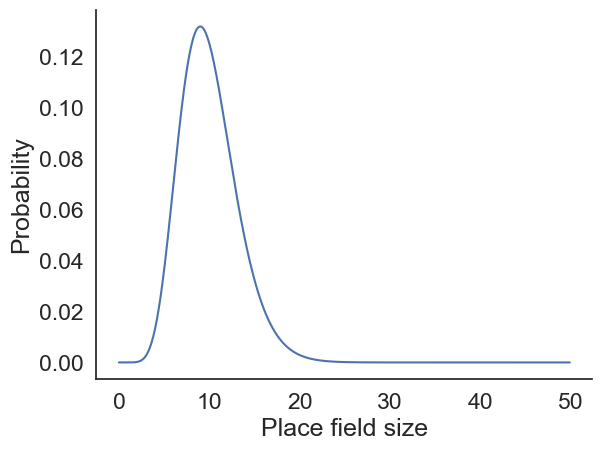

In [4]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

In [5]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Text(0, 0.5, 'cell #')

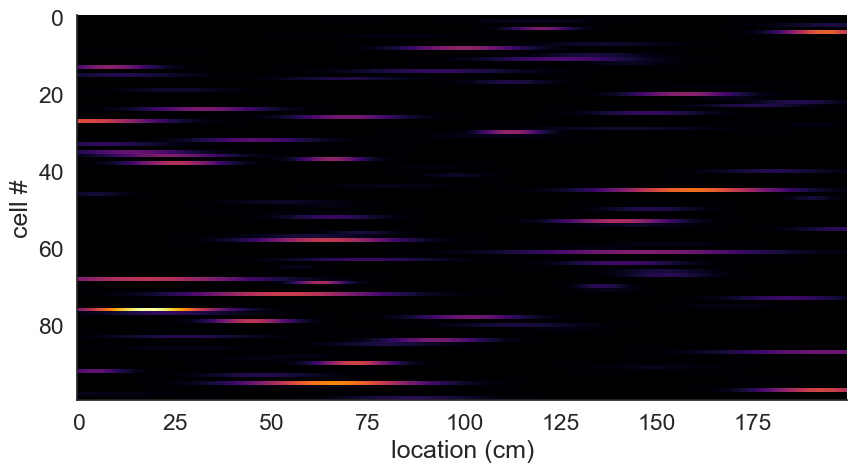

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

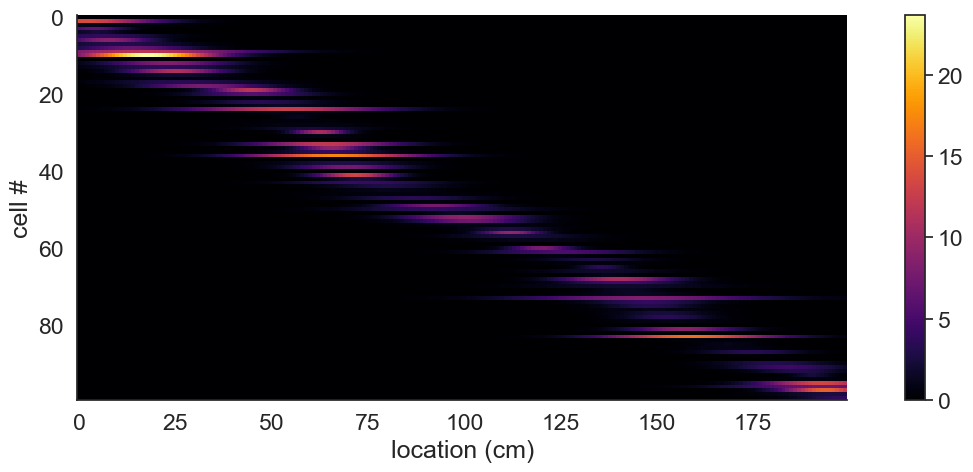

In [7]:
plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

In [8]:
n_runs = 20 
av_running_speed = 10 
fps = 30 # "frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

Text(0, 0.5, 'position on track (cm)')

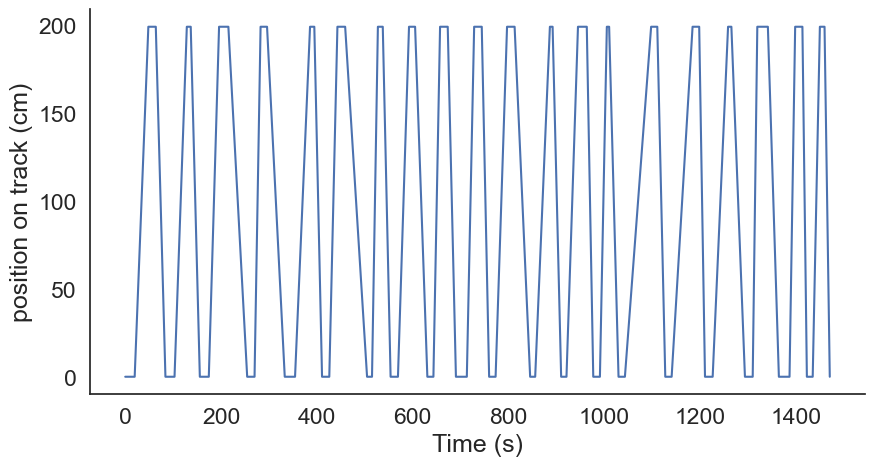

In [9]:
plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

In [10]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.4 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


In [11]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [12]:
spike_positions = [np.interp(s, t, x) for s in spikes]

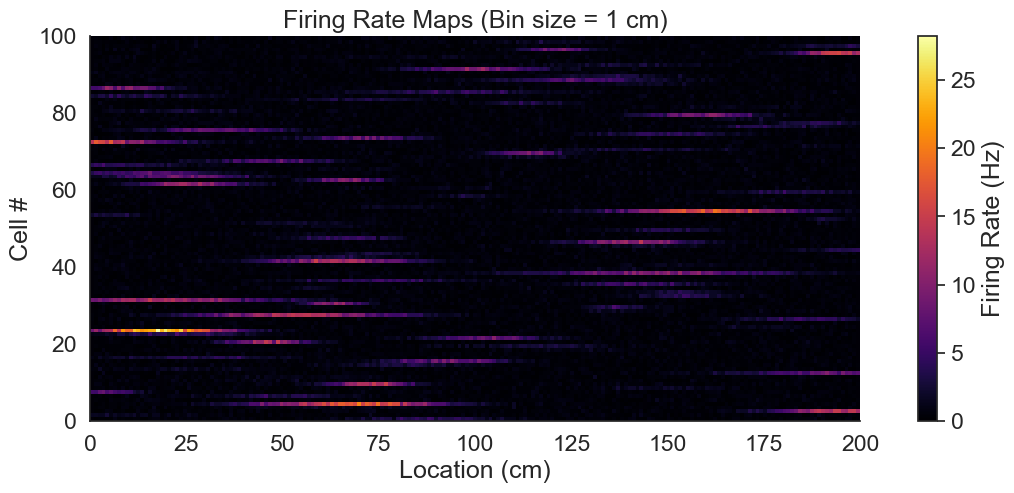

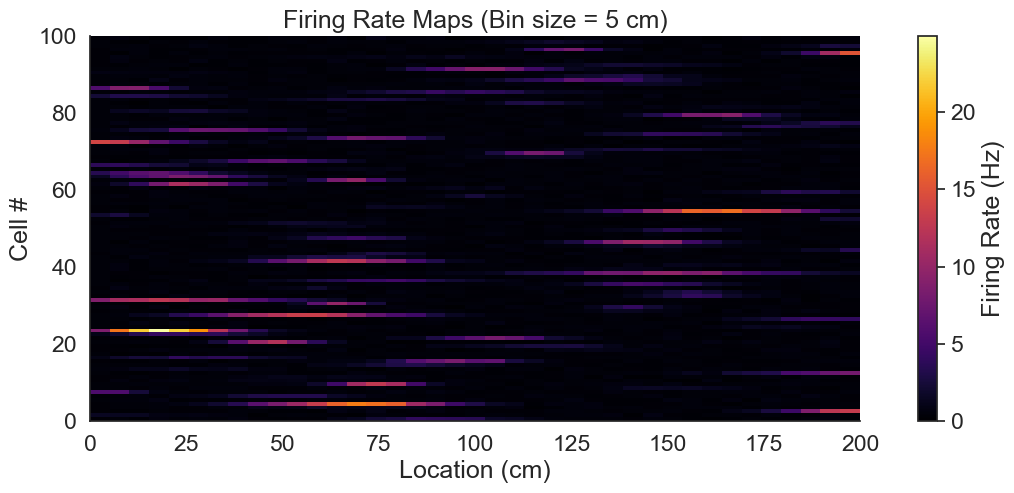

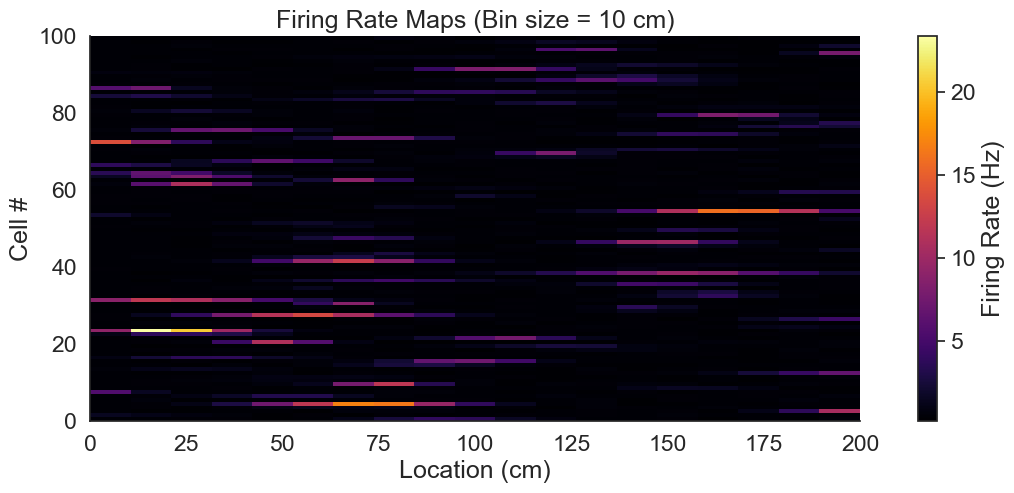

In [13]:
# Function to compute and plot firing rate maps
def compute_and_plot_firing_rate_maps(space_bins, bin_size):
    # Compute spike histograms for each cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # Compute occupancy histogram
    occupancy = np.histogram(x, space_bins)[0] / fps
    
    # Compute firing rate maps
    firing_rate_maps = spikes_hist / occupancy
    
    # Plot firing rate maps
    plt.figure(figsize=(15, 5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Firing Rate Maps (Bin size = {bin_size} cm)')
    plt.xlabel('Location (cm)')
    plt.ylabel('Cell #')
    plt.colorbar(label='Firing Rate (Hz)')
    plt.show()

# Bin sizes to analyze
bin_sizes = [1, 5, 10]

# Generate and plot firing rate maps for each bin size
for bin_size in bin_sizes:
    space_bins = np.arange(0., 200., bin_size)
    compute_and_plot_firing_rate_maps(space_bins, bin_size)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


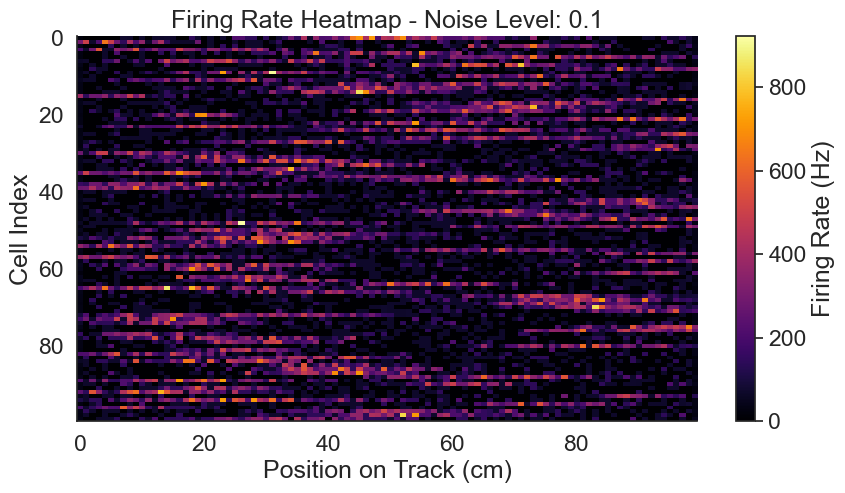

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


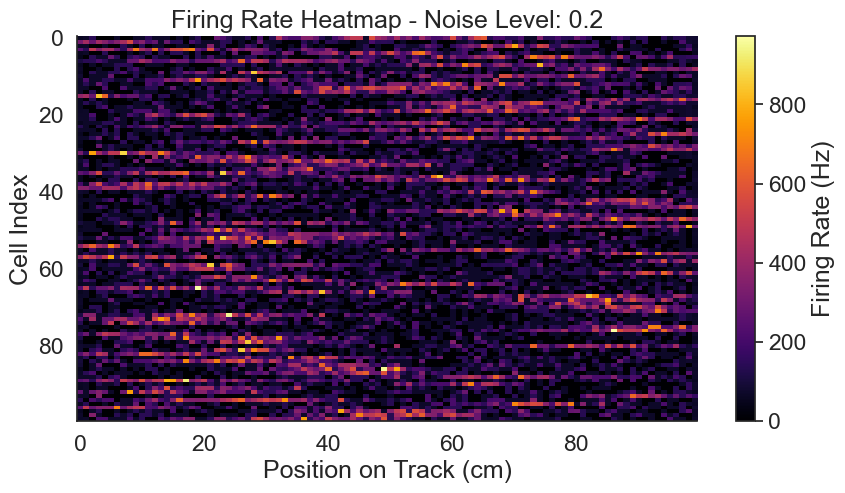

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


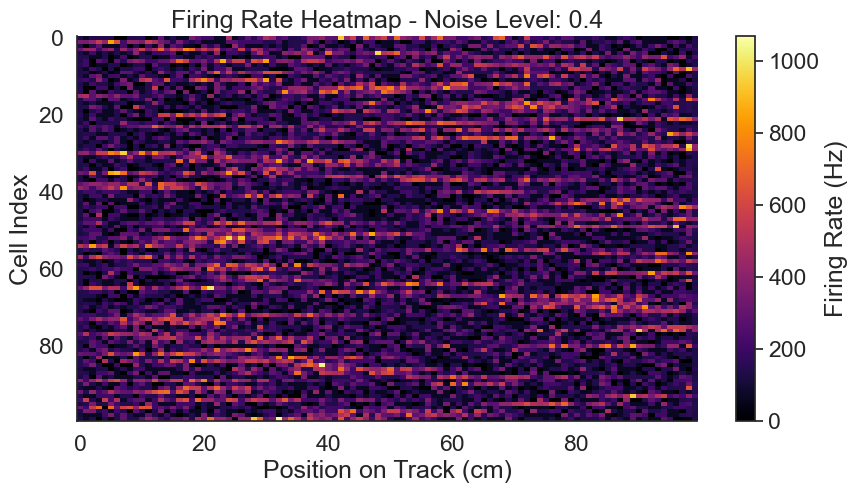

In [22]:



# Function to create true firing rate maps
def create_true_firing_rate_maps():
    true_firing_rate_maps = np.zeros((n_cells, len(bins) - 1))
    for i in range(n_cells):
        center = np.random.choice(len(bins) - 1)
        width = np.random.uniform(5, 15)
        true_firing_rate_maps[i, :] = np.exp(-0.5 * ((np.arange(len(bins) - 1) - center) ** 2) / width ** 2)
    return true_firing_rate_maps

# Generate true firing rate maps
true_firing_rate_maps = create_true_firing_rate_maps()

# Function to simulate spikes
def simulate_spikes(noise_firing_rate):
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    return spikes

# Function to create firing rate maps
def create_firing_rate_map(spikes):
    spike_positions = [np.interp(s, t, x) for s in spikes]
    firing_rate_map = np.zeros((n_cells, len(bins) - 1))
    occupancy, _ = np.histogram(x, bins=bins)
    occupancy = occupancy / sampling_rate
    for i in range(n_cells):
        spike_count, _ = np.histogram(spike_positions[i], bins=bins)
        firing_rate_map[i, :] = spike_count / (occupancy + 1e-9)  # Avoid division by zero
    return firing_rate_map

# Function to plot heatmaps
def plot_heatmap(firing_rate_map, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(firing_rate_map, aspect='auto', cmap='inferno', interpolation='nearest')
    plt.colorbar(label='Firing Rate (Hz)')
    plt.title(title)
    plt.xlabel('Position on Track (cm)')
    plt.ylabel('Cell Index')
    plt.show()

# Define noise levels to experiment with
noise_levels = [0.1, 0.2, 0.4]

# Simulate and plot for different noise levels
for noise_level in noise_levels:
    spikes = simulate_spikes(noise_level)
    firing_rate_map = create_firing_rate_map(spikes)
    plot_heatmap(firing_rate_map, f'Firing Rate Heatmap - Noise Level: {noise_level}')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


In [34]:
from scipy.stats import gaussian_kde

space_bins = np.arange(0., 200., 0.1)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

smoothened_firing_rate_maps = gaussian_kde(firing_rate_maps)

C:\Users\Jelle\AppData\Local\Temp\ipykernel_25756\2898373740.py:14: RuntimeWarning: divide by zero encountered in divide
  firing_rate_maps = spikes_hist / occupancy
C:\Users\Jelle\AppData\Local\Temp\ipykernel_25756\2898373740.py:14: RuntimeWarning: invalid value encountered in divide
  firing_rate_maps = spikes_hist / occupancy


ValueError: array must not contain infs or NaNs